In [1]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#consum_data = pd.read_csv('data/LD2011_2014.txt', skiprows=1, usecols=[0, 250], delimiter=';', names=['Time', 'KW'], low_memory=False)
#consum_data['KW'] = consum_data['KW'].map(lambda x : float(re.sub(',', '.', x)))

In [3]:
consum_data = pd.read_csv('data/LD2011_2014_C250.csv', low_memory=False)

In [4]:
consum_data.head(5)

,Time,KW
0,2011-01-01 00:15:00,46.686084
1,2011-01-01 00:30:00,48.634304
2,2011-01-01 00:45:00,49.928803
3,2011-01-01 01:00:00,51.223301
4,2011-01-01 01:15:00,51.223301


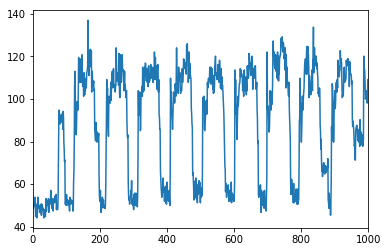

In [5]:
plt.figure()
consum_data['KW'][1:1000].plot()
plt.show()

In [75]:
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import math

In [76]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data = scaler.fit_transform(consum_data['KW'].values.reshape(-1, 1))

In [77]:
data

array([[ 0.25384973],
       [ 0.26460395],
       [ 0.27174962],
       ..., 
       [ 0.29675944],
       [ 0.29318661],
       [ 0.27889528]])

In [88]:
STATELESS = False

NUM_TIMESTEPS = 20
HIDDEN_SIZE = 10
BATCH_SIZE = 96 # 24 hour (15 min intervals)
NUM_EPOCHS = 5

In [79]:
X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]

# reshape X to three dimensions (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

In [80]:
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(98179, 20, 1) (42077, 20, 1) (98179, 1) (42077, 1)


In [81]:
if STATELESS:
    # stateless
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, input_shape=(NUM_TIMESTEPS, 1), return_sequences=False))
    model.add(Dense(1))
else:
    # stateful
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, stateful=True, batch_input_shape=(BATCH_SIZE, NUM_TIMESTEPS, 1), return_sequences=False))
    model.add(Dense(1))

In [82]:
model.compile(loss="mean_squared_error",optimizer="adam", metrics=["mean_squared_error"])

In [90]:
if STATELESS:
    # stateless
    model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(Xtest, Ytest), shuffle=False)
else:
    # stateful
    # ned to make training and test data to multiple of BATCH_SIZE
    train_size = (Xtrain.shape[0] // BATCH_SIZE) * BATCH_SIZE
    test_size = (Xtest.shape[0] // BATCH_SIZE) * BATCH_SIZE
    Xtrain, Ytrain = Xtrain[0:train_size], Ytrain[0:train_size]
    Xtest, Ytest = Xtest[0:test_size], Ytest[0:test_size]
    print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
    for i in range(NUM_EPOCHS):
        print("Epoch {:d}/{:d}".format(i+1, NUM_EPOCHS))
        model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=1, validation_data=(Xtest, Ytest), shuffle=False)
        model.reset_states()

(98112, 20, 1) (42048, 20, 1) (98112, 1) (42048, 1)
Epoch 1/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 39s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 39s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 40s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 39s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/9811

In [91]:
score, _ = model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)

41472/42048 [============================>.] - ETA: 0s

In [92]:
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))


MSE: 0.002, RMSE: 0.047
